In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
import tensorflow as tf
from tensorflow.keras import regularizers



<h3>Prepare Datasets</h3>

In [3]:
train_dataset = pd.read_csv('Datasets/train_dataset.csv')
test_dataset = pd.read_csv('Datasets/test_dataset.csv')

train_pca_dataset = pd.read_csv('Datasets/PCA_train_data.csv')
test_pca_dataset = pd.read_csv('Datasets/PCA_test_data.csv')

train_tree_dataset = pd.read_csv('Datasets/Tree_train_data.csv')
test_tree_dataset = pd.read_csv('Datasets/Tree_test_data.csv')


X_train = train_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_train = train_dataset['attack_category']

X_test = test_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_test = test_dataset['attack_category']

from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

X_pca_train = train_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_train = train_pca_dataset['attack_category']

X_pca_test = test_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_test = test_pca_dataset['attack_category']

X_tree_train = train_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_train = train_tree_dataset['attack_category']

X_tree_test = test_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_test = test_tree_dataset['attack_category']

In [4]:
def train_model(model, X, y):
    skf = StratifiedKFold(n_splits=5)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average='weighted')
        recall = recall_score(y_test, pred, average='weighted') 
        f1 = f1_score(y_test, pred, average='weighted') 

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # print('{0} Accuracy: {1: .5f} Precision: {2: .5f} Recall: {3: .5f} F1_Score: {4: .5f}'.format(
    #     model.__class__.__name__, 
    #     np.mean(accuracy_scores),
    #     np.mean(precision_scores),
    #     np.mean(recall_scores),
    #     np.mean(f1_scores)))
    
    return -np.mean(f1_scores)

In [5]:
def evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Model: ", model.__class__.__name__)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("####################################")
    
    # report = classification_report(y_test, y_pred)
    # print("Classification Report:\n", report)
    
    return -f1

<h3> Model for Neural Network without PCA or Tree </h3>

In [7]:
num_classes = 5
tf.random.set_seed(42)
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])


In [8]:
nn_model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


In [9]:
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                2944      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               66048     
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [10]:
nn_history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 24s 6ms/step - loss: 0.1842 - accuracy: 0.9644 - val_loss: 1.4185 - val_accuracy: 0.7568
Epoch 2/10
3937/3937 [==============================] - 23s 6ms/step - loss: 0.1008 - accuracy: 0.9777 - val_loss: 1.3536 - val_accuracy: 0.7606
Epoch 3/10
3937/3937 [==============================] - 22s 6ms/step - loss: 0.0898 - accuracy: 0.9801 - val_loss: 1.7527 - val_accuracy: 0.7508
Epoch 4/10
3937/3937 [==============================] - 23s 6ms/step - loss: 0.0840 - accuracy: 0.9818 - val_loss: 1.4603 - val_accuracy: 0.7712
Epoch 5/10
3937/3937 [==============================] - 22s 6ms/step - loss: 0.0828 - accuracy: 0.9823 - val_loss: 1.3630 - val_accuracy: 0.7529
Epoch 6/10
3937/3937 [==============================] - 22s 6ms/step - loss: 0.0824 - accuracy: 0.9824 - val_loss: 1.6303 - val_accuracy: 0.7363
Epoch 7/10
3937/3937 [==============================] - 22s 6ms/step - loss: 0.0802 - accuracy: 0.9835 - val_loss: 1.6632 - val_ac

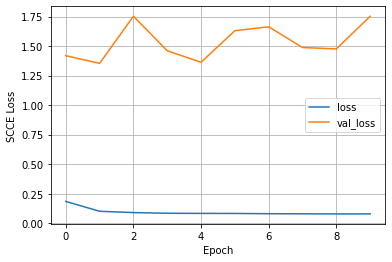

In [11]:
plt.plot(nn_history.history['loss'], label='loss')
plt.plot(nn_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

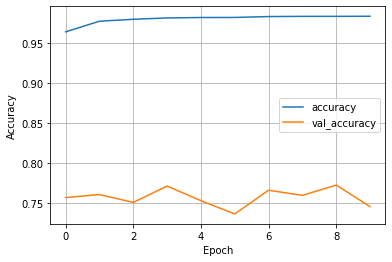

In [12]:
plt.plot(nn_history.history['accuracy'], label='accuracy')
plt.plot(nn_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [13]:
y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy for no PCA and no tree:", accuracy)
print("Precision for no PCA and no tree:", precision)
print("Recall for no PCA and no tree:", recall)
print("F1 Score for no PCA and no tree:", f1)

705/705 [==============================] - 1s 2ms/step
Accuracy for no PCA and no tree: 0.7454755145493258
Precision for no PCA and no tree: 0.7682613607563826
Recall for no PCA and no tree: 0.7454755145493258
F1 Score for no PCA and no tree: 0.6957058930362443


<h3> Neural networks with PCA </h3>

In [14]:
tf.random.set_seed(42)
nn_model_pca = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_pca_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [15]:
nn_model_pca.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [16]:
nn_history_pca = nn_model_pca.fit(X_pca_train, y_pca_train, validation_data=(X_pca_test, y_pca_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 22s 5ms/step - loss: 0.2091 - accuracy: 0.9573 - val_loss: 1.4144 - val_accuracy: 0.7449
Epoch 2/10
3937/3937 [==============================] - 21s 5ms/step - loss: 0.1247 - accuracy: 0.9707 - val_loss: 1.2184 - val_accuracy: 0.7602
Epoch 3/10
3937/3937 [==============================] - 22s 5ms/step - loss: 0.1117 - accuracy: 0.9727 - val_loss: 1.5607 - val_accuracy: 0.7671
Epoch 4/10
3937/3937 [==============================] - 21s 5ms/step - loss: 0.1082 - accuracy: 0.9738 - val_loss: 1.5493 - val_accuracy: 0.7659
Epoch 5/10
3937/3937 [==============================] - 20s 5ms/step - loss: 0.1067 - accuracy: 0.9738 - val_loss: 1.0958 - val_accuracy: 0.7792
Epoch 6/10
3937/3937 [==============================] - 20s 5ms/step - loss: 0.1038 - accuracy: 0.9740 - val_loss: 1.7204 - val_accuracy: 0.7574
Epoch 7/10
3937/3937 [==============================] - 20s 5ms/step - loss: 0.1039 - accuracy: 0.9742 - val_loss: 1.4008 - val_ac

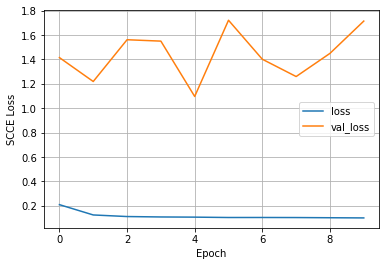

In [17]:
plt.plot(nn_history_pca.history['loss'], label='loss')
plt.plot(nn_history_pca.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

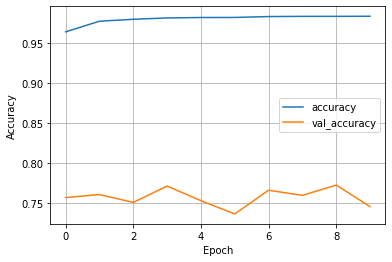

In [18]:
plt.plot(nn_history.history['accuracy'], label='accuracy')
plt.plot(nn_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [19]:
y_pred_probs_pca = nn_model_pca.predict(X_pca_test)
y_pred_pca = np.argmax(y_pred_probs_pca, axis=-1)


accuracy_pca = accuracy_score(y_pca_test, y_pred_pca)
precision_pca = precision_score(y_pca_test, y_pred_pca, average='weighted')
recall_pca = recall_score(y_pca_test, y_pred_pca, average='weighted')
f1_pca = f1_score(y_pca_test, y_pred_pca, average='weighted')

# Print the metrics
print("Accuracy for PCA:", accuracy_pca)
print("Precision for PCA:", precision_pca)
print("Recall for PCA:", recall_pca)
print("F1 Score for PCA:", f1_pca)

705/705 [==============================] - 1s 910us/step
Accuracy for PCA: 0.7523509581263307
Precision for PCA: 0.6871563444508342
Recall for PCA: 0.7523509581263307
F1 Score for PCA: 0.7029391239293264


<h3> Neural networks for tree </h3>

In [20]:
nn_model_tree = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_tree_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [21]:
nn_model_tree.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [22]:
nn_history_tree = nn_model_tree.fit(X_tree_train, y_tree_train, validation_data=(X_tree_test, y_tree_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 21s 5ms/step - loss: 0.1886 - accuracy: 0.9623 - val_loss: 1.3407 - val_accuracy: 0.7734
Epoch 2/10
3937/3937 [==============================] - 21s 5ms/step - loss: 0.1018 - accuracy: 0.9767 - val_loss: 1.4322 - val_accuracy: 0.7643
Epoch 3/10
3937/3937 [==============================] - 20s 5ms/step - loss: 0.0893 - accuracy: 0.9795 - val_loss: 1.6787 - val_accuracy: 0.7722
Epoch 4/10
3937/3937 [==============================] - 20s 5ms/step - loss: 0.0855 - accuracy: 0.9809 - val_loss: 1.5073 - val_accuracy: 0.7630
Epoch 5/10
3937/3937 [==============================] - 20s 5ms/step - loss: 0.0817 - accuracy: 0.9821 - val_loss: 1.1883 - val_accuracy: 0.7619
Epoch 6/10
3937/3937 [==============================] - 21s 5ms/step - loss: 0.0815 - accuracy: 0.9823 - val_loss: 1.5881 - val_accuracy: 0.7740
Epoch 7/10
3937/3937 [==============================] - 20s 5ms/step - loss: 0.0814 - accuracy: 0.9824 - val_loss: 1.5852 - val_ac

In [23]:
y_pred_probs_tree = nn_model_tree.predict(X_tree_test)
y_pred_tree = np.argmax(y_pred_probs_tree, axis=-1)


accuracy_tree = accuracy_score(y_tree_test, y_pred_tree)
precision_tree = precision_score(y_tree_test, y_pred_tree, average='weighted')
recall_tree = recall_score(y_tree_test, y_pred_tree, average='weighted')
f1_tree= f1_score(y_tree_test, y_pred_tree, average='weighted')

# Print the metrics
print("Accuracy for PCA:", accuracy_tree)
print("Precision for PCA:", precision_tree)
print("Recall for PCA:", recall_tree)
print("F1 Score for PCA:", f1_tree)

705/705 [==============================] - 1s 945us/step
Accuracy for PCA: 0.757097232079489
Precision for PCA: 0.7863813705665348
Recall for PCA: 0.757097232079489
F1 Score for PCA: 0.7084096654943077
